In [37]:
import pandas as pd
import numpy as np

In [38]:
df = pd.read_csv('dataset_with_anomalies.csv')
df.head(2)

pickup_datetime     dropoff_datetime  pickup_latitude  \
0  2023-02-20 17:27:00  2023-02-20 17:49:00        40.808941   
1  2023-02-28 19:41:00  2023-02-28 20:07:00        40.685842   

   pickup_longitude  dropoff_latitude  dropoff_longitude  trip_distance_miles  \
0        -73.914482         40.807336         -73.905270                 1.03   
1        -73.855449         40.663358         -73.826745                 4.02   

  fare_amount  passenger_count payment_type  
0       5.84$              5.0  Credit Card  
1       15.6£              4.0      Unknown

In [43]:
df.shape

(824, 10)

# Skimming Data

In [44]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100,
    'neg_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    'duplicate' : df.duplicated().sum(),
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]}
).round(3)

feature data_type  null_value(%)  neg_value(%)  0_value(%)  \
0      pickup_datetime    object          4.854           0.0         0.0   
1     dropoff_datetime    object          0.000           0.0         0.0   
2      pickup_latitude   float64          0.000           0.0         0.0   
3     pickup_longitude   float64          0.000         100.0         0.0   
4     dropoff_latitude   float64          0.000           0.0         0.0   
5    dropoff_longitude   float64          0.000         100.0         0.0   
6  trip_distance_miles   float64          4.854           0.0         0.0   
7          fare_amount    object          4.490           0.0         0.0   
8      passenger_count   float64          4.854           0.0         0.0   
9         payment_type    object          0.000           0.0         0.0   

   duplicate  n_unique                                      sample_unique  
0          9       761  [2023-02-20 17:27:00, 2023-02-28 19:41:00, 202...  
1          9       797  [2023-02-20 17:49:00, 2023-02-28 20:07:00, 202...  
2          9       803  [40.808941, 40.685842, 40.668055, 40.765394, 4...  
3          9       802  [-73.914482, -73.855449, -74.04505, -73.753324...  
4          9       803  [40.807336, 40.663358, 40.642572, 40.775285, 4...  
5          9       802  [-73.90527, -73.826745, -74.055617, -73.775441...  
6          9       332  [1.03, 4.02, 3.04, 2.67, 3.11, 4.18, 2.27, 4.0...  
7          9       678  [5.84$, 15.6£, 2192.65¥, 9.38€, 13.7€, 10.08£,...  
8          9         5                     [5.0, 4.0, 3.0, 2.0, 1.0, nan]  
9          9         9  [Credit Card, Unknown, Cash, credit card, CRED...

### Synthèse skimming

- **Valeurs manquantes** :
  - `pickup_datetime` (~ 5%), `trip_distance_miles` (~ 5%), `fare_amount` ~ 5%), `passenger_count` (~ 5%).

- **Formats incorrects** :
  - `pickup_datetime` et `dropoff_datetime` : doivent être en `datetime` (actuellement `object`).
  - `fare_amount` : mélange de devises ($, £, ¥, €) et format `object`.

- **Doublons de ligne** :
  - 12 doublons 

- **Standardisation** :
  - `payment_type` : valeurs non uniformes (ex: "Credit Card" vs "CREDIT CARD").



In [45]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
html = profile.to_html()
with open("profiling_report.html", "w", encoding="utf-8") as f:
    f.write(html)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 207.23it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
profile.to_notebook_iframe()

### Synthèse du Rapport de Profiling

- **Nombre d'observations** : 824
- **Cellules manquantes** : 157 (1.9%)
- **Lignes dupliquées** : 9 (1.5%)
- On peut lire egalement la presence de correlation entre plusieurs variables**Corrélations** : Approfondir l'analyse des interactions entre les variables.
- Les colonnes de **dates** ont toutes des valeurs valides
- La colonne passenger_count a des valeurs toutes comprises [1,5] ce qui est correct



### Assessment Scénario Driver

In [73]:
cols = ["fare_amount", "trip_distance_miles", "pickup_datetime", "dropoff_datetime", "pickup_latitude", "pickup_longitude"]
driver_scenario_df = df[cols]

# 1) Complétude (%) par colonne
compl_pct = (driver_scenario_df.notna().mean() * 100).round(2)
compl_df = compl_pct.reset_index()
compl_df.columns = ["feature", "completeness_pourcent"]
print("--- Complétude (%) ---")
display(compl_df)

--- Complétude (%) ---


feature  completeness_pourcent
0          fare_amount                  95.51
1  trip_distance_miles                  95.15
2      pickup_datetime                  95.15
3     dropoff_datetime                 100.00
4      pickup_latitude                 100.00
5     pickup_longitude                 100.00

1- Evaluons l'accuracy des attributs

In [75]:
acc_df = driver_scenario_df.copy()
# Référence temporelle
now = pd.Timestamp.now()

# Parsing des dates
pickup = pd.to_datetime(acc_df['pickup_datetime'], errors='coerce')
dropoff = pd.to_datetime(acc_df['dropoff_datetime'], errors='coerce')

# Masks de validité de dates (pas NaT, pas de dates dans le futur, et bon ordre de date)
valid_pickup = pickup.notna() & (pickup <= now) & ~((pickup >= dropoff) & dropoff.notna())
valid_dropoff = dropoff.notna() & (dropoff <= now) & ~((dropoff <= pickup) & pickup.notna())

pu_accuracy_pct = valid_pickup.mean() * 100
do_accuracy_pct = valid_dropoff.mean() * 100

print(f"Accuracy pickup_datetime (en %): {pu_accuracy_pct:.2f}")
print(f"Accuracy dropoff_datetime (en %): {do_accuracy_pct:.2f}")





Accuracy pickup_datetime (en %): 85.44
Accuracy dropoff_datetime (en %): 90.17


In [76]:
acc_df['fare_amount']

0         5.84$
1         15.6£
2      2192.65¥
3         9.38€
4         13.7€
         ...   
819       6.75€
820       13.3£
821      13.57€
822      13.52€
823       9.88€
Name: fare_amount, Length: 824, dtype: object

Comme vu précédement les valeurs de fare_amount sont des string et pas sous les memes unités. 

In [77]:
# Fonction pour extraire la valeur numérique et convertir en USD
def convert_to_usd(fare):
    if isinstance(fare, str):
        if '€' in fare:
            amount = float(fare.replace('€', '').strip())
            return amount * 1.18  # 1 EUR = 1.18 USD
        elif '£' in fare:
            amount = float(fare.replace('£', '').strip())
            return amount * 1.33  # 1 GBP = 1.33 USD
        elif '¥' in fare:
            amount = float(fare.replace('¥', '').strip())
            return amount * 0.009  # 1 JPY = 0.009 USD
        elif '$' in fare:
            amount = float(fare.replace('$', '').strip())
            return amount  # Déjà en USD
        else:
            return float(fare)  # Si pas de symbole (ex: '0')
    else:
        return float(fare)  # Si déjà numérique


acc_df['dollar_fareamount'] = acc_df['fare_amount'].apply(convert_to_usd)

# Afficher le résultat
acc_df['dollar_fareamount'].head(5)


0     5.84000
1    20.74800
2    19.73385
3    11.06840
4    16.16600
Name: dollar_fareamount, dtype: float64

In [80]:
#fare_amount accuracy (valeur negative ou 0), (accuracy %)
neg_fare_count = (acc_df['dollar_fareamount'] < 0).sum()
zero_fare_count = (acc_df['dollar_fareamount'] == 0).sum()
total = len(acc_df)
fare_accuracy_pct = ((total - (neg_fare_count + zero_fare_count)) / total) * 100
print(f"fare_amount accuracy en % : {fare_accuracy_pct:.2f}")


fare_amount accuracy en % : 97.09


In [81]:
# accuracy pour trip_distance_miles (valeur negative ou 0), (accuracy %)
neg_distance_count = (acc_df['trip_distance_miles'] < 0).sum()
zero_distance_count = (acc_df['trip_distance_miles'] == 0).sum()
total = len(acc_df)
distance_accuracy_pct = ((total - (neg_distance_count + zero_distance_count)) / total) * 100
print(f"trip_distance_miles accuracy en % : {distance_accuracy_pct:.2f}")

trip_distance_miles accuracy en % : 100.00


### Consistancy

In [82]:
# verifions la presence ou pas de valeurs aberrantes sur les differents attributs
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,15))
index = 0
axs = axs.flatten()
for k, v in acc_df.select_dtypes(include=[np.number]).items():
    sns.boxplot(y=k, data=acc_df, ax=axs[index])
    index += 1
plt.tight_layout(w_pad=0.5, h_pad=2)
plt.savefig('boxplots_numeric_features.png')

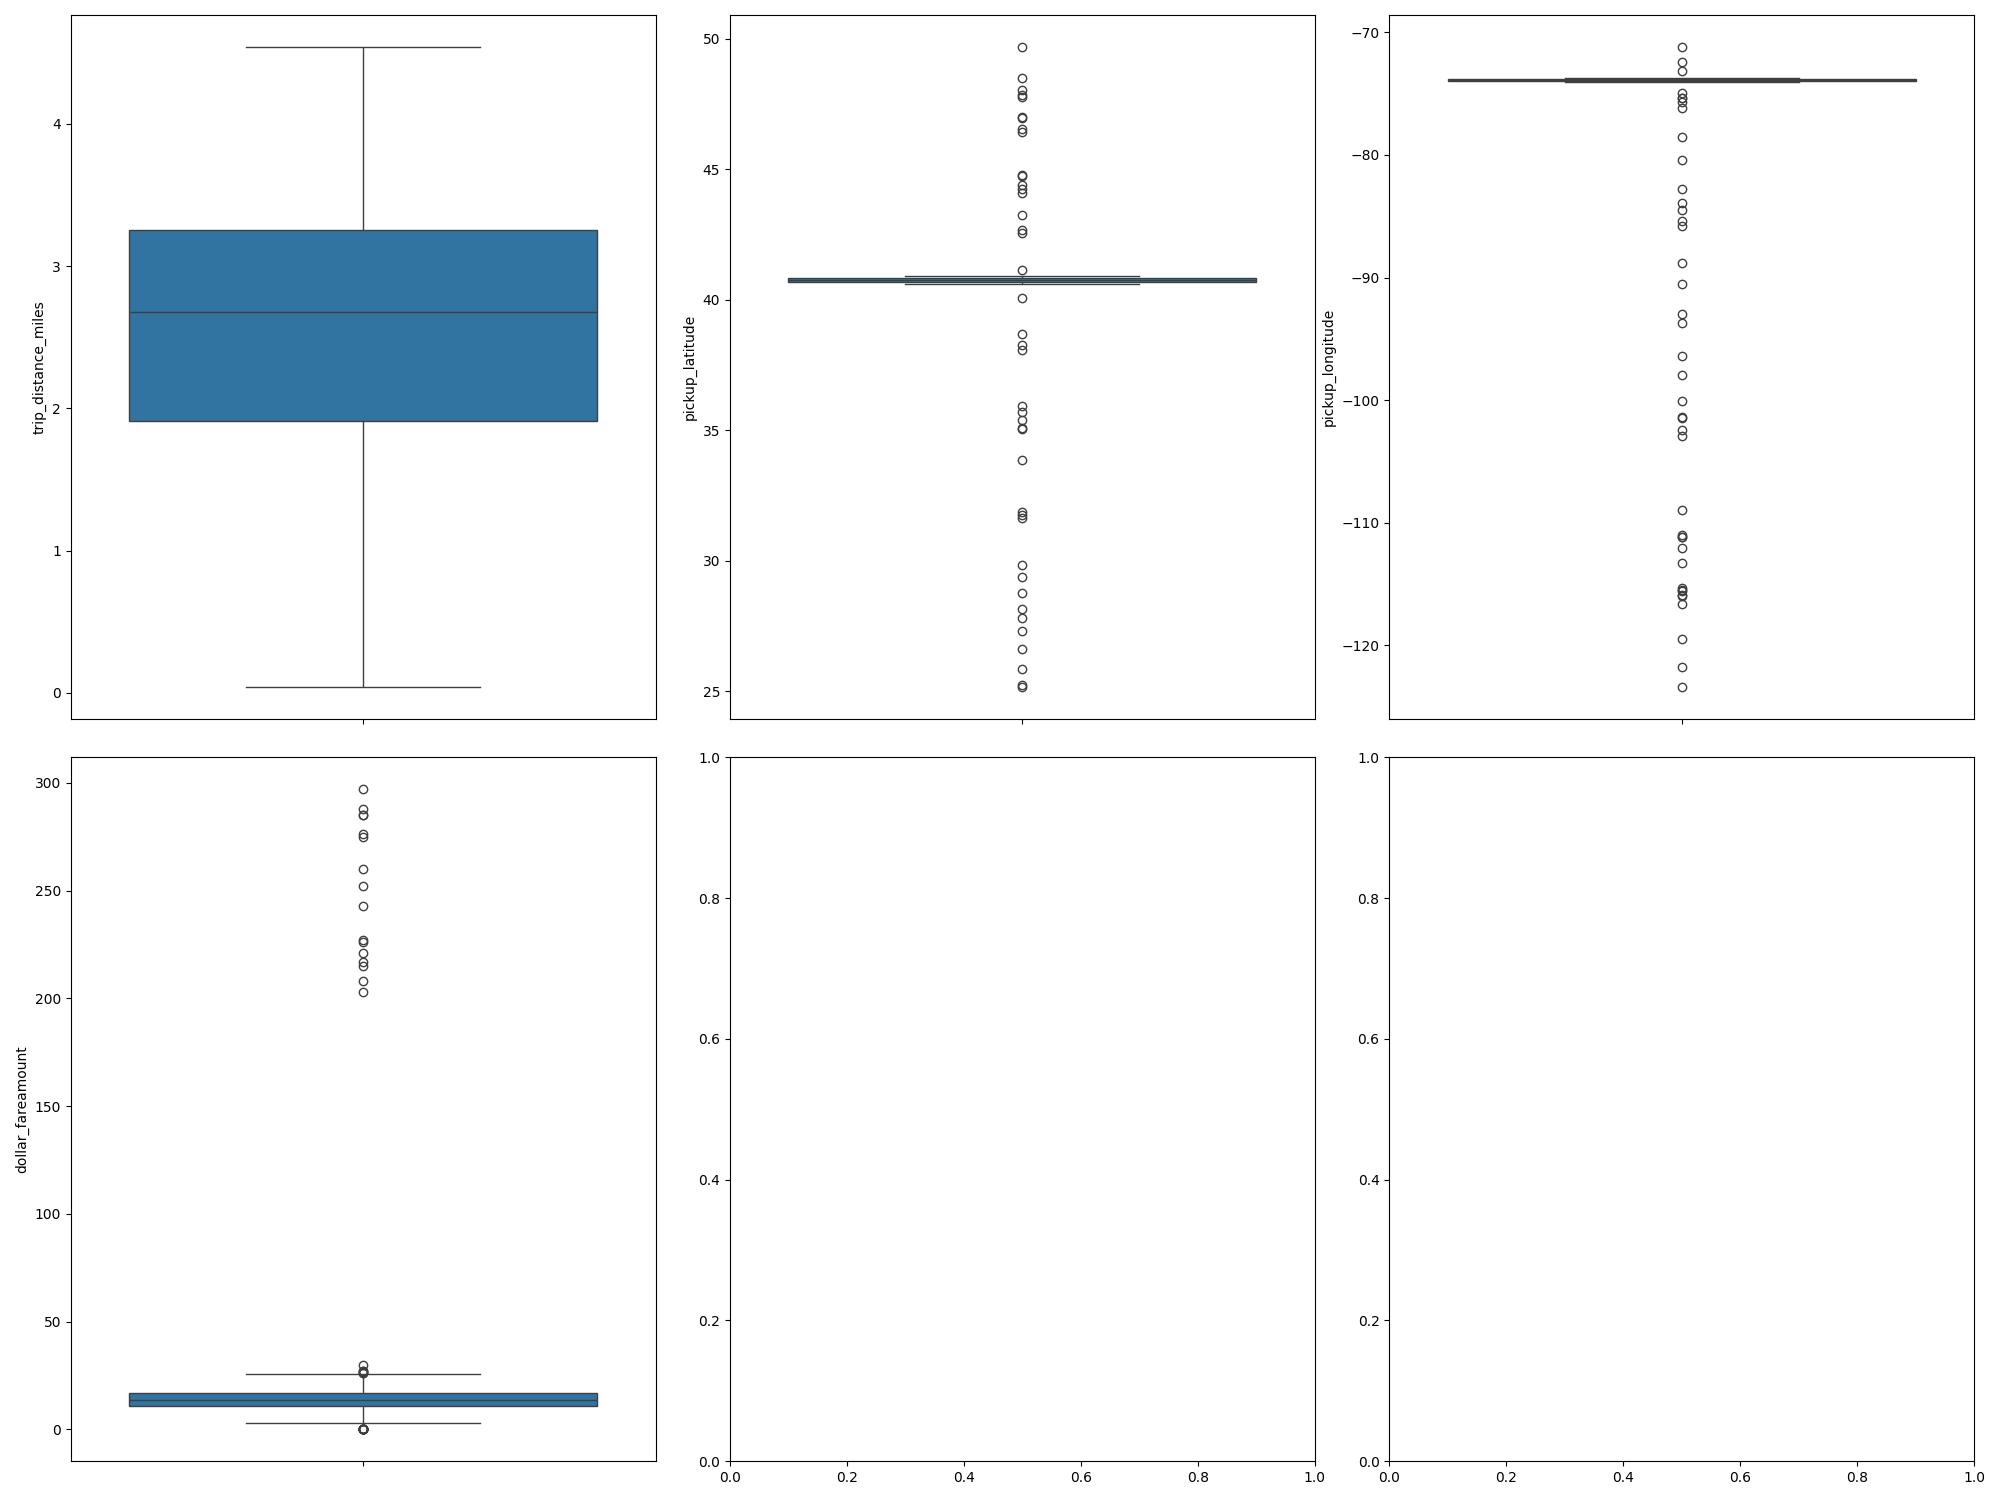

In [84]:
from IPython.display import Image
Image(filename='boxplots_numeric_features.png')

In [85]:
# valeur moyenne et mediane de fare_amount 
mean_fare = acc_df['dollar_fareamount'][acc_df['dollar_fareamount'] > 0].mean()
median_fare = acc_df['dollar_fareamount'][acc_df['dollar_fareamount'] > 0].median()
print(f"Mean fare_amount: {mean_fare:.2f} USD")
print(f"Median fare_amount: {median_fare:.2f} USD")

Mean fare_amount: 18.83 USD
Median fare_amount: 13.65 USD



**`trip_distance_miles`**
- **Distribution** : Majorité des trajets entre 2 et 3 miles (médiane ~2.5 miles).
- Cependant on observe pas de distance hors de la boite à moustache


**`dollar_fareamount`**
- **Distribution** : On a le median qui est à 13 et la moyenne à 18.
- **Valeurs aberrantes** : Certaines valeurs > 250  (vérifier erreurs ou fraudes).



In [86]:
# methode IQR pour calculer la consistence de fare_amount
Q1 = acc_df['dollar_fareamount'].quantile(0.25)
Q3 = acc_df['dollar_fareamount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
consistent_fare_count = acc_df[(acc_df['dollar_fareamount'] >= lower_bound) & (acc_df['dollar_fareamount'] <= upper_bound)].shape[0]
total = len(acc_df)
consistency_pct = (consistent_fare_count / total) * 100
print(f"fare_amount consistency en % : {consistency_pct:.2f}")

fare_amount consistency en % : 89.93


In [88]:
# date inconsistent (pickup >= dropoff)

acc_df['temporal_inconsistent'] = (
    acc_df['pickup_datetime'].notna() &
    acc_df['dropoff_datetime'].notna() &
    (acc_df['pickup_datetime'] >= acc_df['dropoff_datetime'])
).astype(int)

n_bad = acc_df['temporal_inconsistent'].sum()
pct_bad = n_bad / len(acc_df) * 100
print(f"Nombre d'enregistrements temporal_inconsistent : {n_bad} ({pct_bad:.2f}%)")

# afficher quelques exemples pour inspection
display(acc_df[acc_df['temporal_inconsistent'] == 1].head())

Nombre d'enregistrements temporal_inconsistent : 41 (4.98%)


fare_amount  trip_distance_miles      pickup_datetime     dropoff_datetime  \
50       8.57£                 2.01  2023-02-07 07:05:00  2023-02-07 06:15:00   
65      12.38€                 2.52  2023-01-13 18:52:00  2023-01-13 18:37:00   
67       8.13€                 0.77  2023-02-02 10:38:00  2023-02-02 10:12:00   
68       8.13€                 0.77  2023-02-02 10:38:00  2023-02-02 10:12:00   
74       5.95€                 1.37  2023-02-07 22:52:00  2023-02-07 21:56:00   

    pickup_latitude  pickup_longitude  dollar_fareamount  \
50        40.636189        -73.912303            11.3981   
65        40.624958        -73.814556            14.6084   
67        40.673100        -74.014389             9.5934   
68        40.673100        -74.014389             9.5934   
74        40.788175        -73.882554             7.0210   

    temporal_inconsistent  
50                      1  
65                      1  
67                      1  
68                      1  
74                      1

In [58]:
acc_df.dtypes

fare_amount               object
trip_distance_miles      float64
pickup_datetime           object
dropoff_datetime          object
pickup_latitude          float64
pickup_longitude         float64
dollar_fareamount        float64
temporal_inconsistent      int64
dtype: object

In [89]:
# Du rapport data profiling, on a pu constater l'existence d'une corrélation entre fare_amount et trip_distance_miles.
# Analysons le prix par mile 

#parsons fare

acc_df['fare_per_mile'] = acc_df.apply(
    lambda row: row['dollar_fareamount'] / row['trip_distance_miles'] if row['trip_distance_miles'] > 0 else 0,
    axis=1
)

print(acc_df['fare_per_mile'].describe())


count    787.000000
mean       8.163889
std       19.342229
min        0.000000
25%        4.238019
50%        5.230520
75%        6.643597
max      265.882353
Name: fare_per_mile, dtype: float64


On peut voir une très grande difference entre le prix min et max de fare_per_mile

In [90]:
print("Top 5 des courses avec le 'fare_per_mile' le plus élevé:")
display(acc_df.nlargest(5, 'fare_per_mile'))

Top 5 des courses avec le 'fare_per_mile' le plus élevé:


fare_amount  trip_distance_miles      pickup_datetime  \
268         226                 0.85  2023-01-14 11:31:00   
57          252                 1.11  2023-02-12 21:21:00   
484         217                 1.10  2027-01-09 11:44:00   
805         276                 1.83  2023-02-27 13:11:00   
142       4.45€                 0.04  2023-01-18 02:19:00   

        dropoff_datetime  pickup_latitude  pickup_longitude  \
268  2023-01-14 12:20:00        40.897910        -73.830489   
57   2023-02-12 22:08:00        40.804390        -73.908230   
484  2027-01-09 12:07:00        40.811434        -73.795250   
805  2023-02-27 13:35:00        40.754104        -73.926603   
142  2023-01-18 02:31:00        40.735191        -74.044806   

     dollar_fareamount  temporal_inconsistent  fare_per_mile  
268            226.000                      0     265.882353  
57             252.000                      0     227.027027  
484            217.000                      0     197.272727  
805            276.000                      0     150.819672  
142              5.251                      0     131.275000

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot(acc_df['fare_per_mile'][acc_df['fare_per_mile'] > 0].dropna())
plt.title("Box Plot tarif par mile")
plt.ylabel("tarif par Mile")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

C:\Users\H P\AppData\Local\Temp\ipykernel_16576\2470480928.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


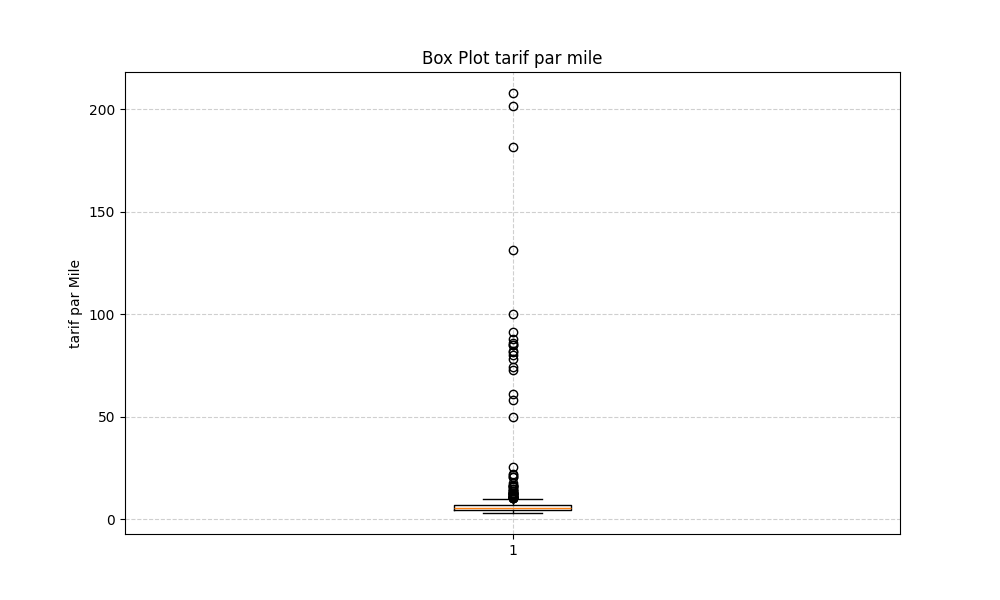

In [92]:
#afficher une image
from IPython.display import Image
Image(filename='boxplot_fare_per_mile.png')


La lecture de cette boite à moustache de la var **fare_per_mile** (variable obtenu par le rapport des var **fare_amount** et **trip_distance_miles**) nous confirme la présence d'aberration sur le couple de variable ( **fare_amount**, **trip_distance_miles**)

La fixation de valeurs seuils (min et max) reste plus ou moins subjectif mais pourrait servir à ici à determiner la consistence des données dans ces 2 colonnes.

In [93]:


# 3. Cohérence du tarif par mile : identification des outliers via IQR
Q1 = acc_df['fare_per_mile'].quantile(0.25)
Q3 = acc_df['fare_per_mile'].quantile(0.75)
IQR = Q3 - Q1

# Définir des bornes pour les outliers (1.5 * IQR est une méthode courante)
lower_bound_fare_per_mile = Q1 - 1.5 * IQR
upper_bound_fare_per_mile = Q3 + 1.5 * IQR

# Assurer que la borne inférieure n'est pas négative, car le tarif par mile doit être positif
lower_bound_fare_per_mile = max(0, lower_bound_fare_per_mile)

# Calculer le pourcentage de 'fare_per_mile' dans la fourchette raisonnable
consistency_fare_per_mile_in_range = (
    (acc_df['fare_per_mile'] >= lower_bound_fare_per_mile) &
    (acc_df['fare_per_mile'] <= upper_bound_fare_per_mile)
).mean() * 100


print(f"\n--- Seuils définis pour 'fare_per_mile' (méthode IQR) ---")
print(f"Q1 (25e percentile): {Q1:.2f}")
print(f"Q3 (75e percentile): {Q3:.2f}")
print(f"IQR (Interquartile Range): {IQR:.2f}")
print(f"Borne inférieure du 'fare_per_mile' (excluant les outliers): {lower_bound_fare_per_mile:.2f}")
print(f"Borne supérieure du 'fare_per_mile' (excluant les outliers): {upper_bound_fare_per_mile:.2f}")
print(f"3. Pourcentage de 'fare_per_mile' dans la fourchette des valeurs consistantes: {consistency_fare_per_mile_in_range:.2f}%")


--- Seuils définis pour 'fare_per_mile' (méthode IQR) ---
Q1 (25e percentile): 4.24
Q3 (75e percentile): 6.64
IQR (Interquartile Range): 2.41
Borne inférieure du 'fare_per_mile' (excluant les outliers): 0.63
Borne supérieure du 'fare_per_mile' (excluant les outliers): 10.25
3. Pourcentage de 'fare_per_mile' dans la fourchette des valeurs consistantes: 80.95%


In [94]:
#consistency sur pickup_latitude        pickup_longitude, les coordonnées vraimeent dans new york
# Approximation coordonnées ville de new York
nyc_min_latitude = 40.5
nyc_max_latitude = 40.9
nyc_min_longitude = -74.25
nyc_max_longitude = -73.7

# On verifie si les valeur pickup sont dans NYC
acc_df['is_pickup_in_nyc'] = (
    (acc_df['pickup_latitude'] >= nyc_min_latitude) &
    (acc_df['pickup_latitude'] <= nyc_max_latitude) &
    (acc_df['pickup_longitude'] >= nyc_min_longitude) &
    (acc_df['pickup_longitude'] <= nyc_max_longitude)
)

# Pourcentage coordonnées valides
percentage_in_nyc = acc_df['is_pickup_in_nyc'].mean() * 100
percentage_in_nyc

np.float64(95.02427184466019)

### plausibility dimension

In [95]:
# sur la vitesse en utilisant les champs pickup_datetime, dropoff_datetime et trip_distance_miles
from datetime import timedelta  
def calculate_speed(row):
    try:
        pickup_time = pd.to_datetime(row['pickup_datetime'])
        dropoff_time = pd.to_datetime(row['dropoff_datetime'])
        trip_distance = row['trip_distance_miles']
        
        if pd.isna(pickup_time) or pd.isna(dropoff_time) or trip_distance <= 0:
            return np.nan
        
        trip_duration = (dropoff_time - pickup_time).total_seconds() / 3600  # durée en heures
        if trip_duration <= 0:
            return np.nan
        
        speed = trip_distance / trip_duration  # vitesse en miles par heure
        return speed
    except Exception as e:
        return np.nan
acc_df['speed_mph'] = acc_df.apply(calculate_speed, axis=1)
print(acc_df['speed_mph'].describe())

count    709.000000
mean      10.038354
std       14.221315
min        0.200000
25%        3.252000
50%        4.989474
75%        9.557143
max      120.900000
Name: speed_mph, dtype: float64


On a une vitesse médiane autour de 5 mph
Ce qui reste cohérent avec du trafic urbain à NYC

75 % des trajets < 10 mph circulation urbaine réaliste

Vitesse minimale = 0.2 mph probable si on a des cas de embouteillages

On peut lire Vitesse maximale = 120.9 mph ce qui rest suspecte en contexte urbain



In [96]:
# calculons le % de la plausibilité de la vitesse en considerant comme raisonnable à NYC une vitesse <=60 mph
plausible_speed_pct = (acc_df['speed_mph'] <= 60).mean() * 100
print(f"Pourcentage de plausibilité de la vitesse (<= 60 mph): {plausible_speed_pct:.2f}%")


Pourcentage de plausibilité de la vitesse (<= 60 mph): 84.22%


### Interprétation (Fitness‑for‑Use) - Scénario Driver

**Résumé synthétique :**
- Les erreurs identifiées (valeurs manquantes, valeurs nulles ou zéro sur `fare_amount`/`trip_distance_miles`, dates invalides ou dans le futur, incohérences temporelles `pickup >= dropoff`, doublons, coordonnées hors zone ou lat/lon swap) ont des impacts métiers  pour le scénario Driver.

**Impact métier et priorités d'action :**
- **Manquants sur `fare_amount` / `trip_distance_miles`** : empêche le calcul du revenu et de la distance parcourue, peut donc affecter la facturation, la rémunération.

- **Zéros ou valeurs non‑positives** : peuvent indiquer erreurs d'enregistrement, cause un  faux calcul des recettes 

- **Dates invalides / dates dans le futur** : on a pas la possibilité impossibles de reconstruire les trajets.
- **Incohérences temporelles (pickup >= dropoff)** : On n'a pas de fiabilité sur les durées/vitesses ; traitées dans la dimension *consistency* (priorité élevée si nombreuses). 

- **Outliers tarifaires** : biaisent analyses de tarification 

- **Doublons** : double comptage des trajets cause un biais sur le volumes et recettes 

### Assessment Passenger

In [97]:
passenger_cols = ["fare_amount", "pickup_datetime", "dropoff_datetime", "passenger_count","payment_type"]
passenger_df = df[passenger_cols].copy()

# Complétude (%) par colonne pour Passenger
compl_pct = (passenger_df.notna().mean() * 100).round(2)
compl_df = compl_pct.reset_index()
compl_df.columns = ["feature", "completeness_pourcent"]

print("--- Complétude Passenger (%) ---")
display(compl_df)

--- Complétude Passenger (%) ---


feature  completeness_pourcent
0       fare_amount                  95.51
1   pickup_datetime                  95.15
2  dropoff_datetime                 100.00
3   passenger_count                  95.15
4      payment_type                 100.00

In [98]:
acc_pass_df = passenger_df.copy()
now = pd.Timestamp.now()

# Conversion fare_amount -> USD
acc_pass_df["fare_amount_usd"] = acc_pass_df["fare_amount"].apply(convert_to_usd)
acc_pass_df["fare_amount_usd"] = pd.to_numeric(acc_pass_df["fare_amount_usd"], errors="coerce")

# Dates
pickup = pd.to_datetime(acc_pass_df["pickup_datetime"], errors="coerce")
dropoff = pd.to_datetime(acc_pass_df["dropoff_datetime"], errors="coerce")

valid_pickup = pickup.notna() & (pickup <= now) & ~(pickup >= dropoff)
valid_dropoff = dropoff.notna() & (dropoff <= now) & ~(dropoff <= pickup)

pu_accuracy_pct = valid_pickup.mean() * 100
do_accuracy_pct = valid_dropoff.mean() * 100

print(f"Accuracy pickup_datetime Passenger (en %) : {pu_accuracy_pct:.2f}")
print(f"Accuracy dropoff_datetime Passenger (en %) : {do_accuracy_pct:.2f}")

# Accuracy fare_amount_usd : > 0
neg_fare_count = (acc_pass_df["fare_amount_usd"] <= 0).sum()
total_pass = len(acc_pass_df)
fare_acc_pass = ((total_pass - neg_fare_count) / total_pass) * 100
print(f"Accuracy fare_amount (USD) Passenger (en %) : {fare_acc_pass:.2f}")

Accuracy pickup_datetime Passenger (en %) : 85.44
Accuracy dropoff_datetime Passenger (en %) : 90.17
Accuracy fare_amount (USD) Passenger (en %) : 97.09


In [99]:
# 3) Consistency temporelle Passenger
cons_pass_df = acc_pass_df.copy()
temporal_inconsistent = (
    pickup.notna()
    & dropoff.notna()
    & (dropoff <= pickup)
)

nb_bad = temporal_inconsistent.sum()
pct_bad = nb_bad / len(cons_pass_df) * 100
print(f"Nombre d'enregistrements temporalinconsistent (Passenger) : {nb_bad} ({pct_bad:.2f}%)")
display(cons_pass_df[temporal_inconsistent].head())

Nombre d'enregistrements temporalinconsistent (Passenger) : 41 (4.98%)


fare_amount      pickup_datetime     dropoff_datetime  passenger_count  \
50       8.57£  2023-02-07 07:05:00  2023-02-07 06:15:00              4.0   
65      12.38€  2023-01-13 18:52:00  2023-01-13 18:37:00              2.0   
67       8.13€  2023-02-02 10:38:00  2023-02-02 10:12:00              1.0   
68       8.13€  2023-02-02 10:38:00  2023-02-02 10:12:00              1.0   
74       5.95€  2023-02-07 22:52:00  2023-02-07 21:56:00              NaN   

     payment_type  fare_amount_usd  
50           Cash          11.3981  
65   CREDIT CARD           14.6084  
67   CREDIT CARD            9.5934  
68    Credit Card           9.5934  
74    Credit Card           7.0210

In [100]:
acc_pass_df["fare_amount_usd"] = acc_pass_df["fare_amount"].apply(convert_to_usd)
acc_pass_df["fare_amount_usd"] = pd.to_numeric(acc_pass_df["fare_amount_usd"], errors="coerce")

# Lignes dont le montant est irrécupérable (NaN après conversion)
mask_nan = acc_pass_df["fare_amount_usd"].isna()
print("Nb NaN :", mask_nan.sum())
display(acc_pass_df.loc[mask_nan, ["fare_amount", "fare_amount_usd"]].head(30))


Nb NaN : 37


fare_amount  fare_amount_usd
23          NaN              NaN
27          NaN              NaN
45          NaN              NaN
60          NaN              NaN
69          NaN              NaN
99          NaN              NaN
166         NaN              NaN
182         NaN              NaN
214         NaN              NaN
221         NaN              NaN
231         NaN              NaN
234         NaN              NaN
317         NaN              NaN
324         NaN              NaN
326         NaN              NaN
333         NaN              NaN
338         NaN              NaN
342         NaN              NaN
400         NaN              NaN
424         NaN              NaN
429         NaN              NaN
432         NaN              NaN
438         NaN              NaN
441         NaN              NaN
464         NaN              NaN
522         NaN              NaN
528         NaN              NaN
611         NaN              NaN
622         NaN              NaN
643         NaN              NaN

In [101]:
mask_bad_value = acc_pass_df["fare_amount_usd"].notna() & (acc_pass_df["fare_amount_usd"] <= 0)
print("Nb valeurs <= 0 :", mask_bad_value.sum())
display(acc_pass_df.loc[mask_bad_value, ["fare_amount", "fare_amount_usd"]].head(30))


Nb valeurs <= 0 : 24


fare_amount  fare_amount_usd
16            0              0.0
103           0              0.0
110           0              0.0
128           0              0.0
175           0              0.0
184           0              0.0
247           0              0.0
250           0              0.0
256           0              0.0
302           0              0.0
328           0              0.0
465           0              0.0
560           0              0.0
565           0              0.0
570           0              0.0
582           0              0.0
596           0              0.0
618           0              0.0
640           0              0.0
688           0              0.0
695           0              0.0
752           0              0.0
776           0              0.0
807           0              0.0

In [103]:
# 4) Relevance Passenger (avec fare_amount_usd)
passenger_relevance_conditions = (
    acc_pass_df["fare_amount_usd"].notna() &
    pickup.notna() &
    dropoff.notna() &
    (acc_pass_df["fare_amount_usd"] > 0) &
    (pickup < dropoff)
)

passenger_df["is_relevant_passenger"] = passenger_relevance_conditions.astype(int)
passenger_relevance_score = passenger_df["is_relevant_passenger"].mean() * 100
print(f"Relevance (Passenger) : {passenger_relevance_score:.2f}% de trajets pertinents pour le scénario Passenger")


Relevance (Passenger) : 83.74% de trajets pertinents pour le scénario Passenger
